In [2]:
%matplotlib inline
import sys; sys.path.append(_dh[0].split("visualize patterns")[0] + "visualize patterns")
from lib import *
from lib import db

In [2]:
cits = get_cnt("intext.doc")

loading from ../120 _ count co-occurrences/cnt_doc.pickle
dict_keys(['t', 'ty', 'jt', 'y', 'c', 'j', 'jy', 'cj', 'ac', 'ajy', 'a', 'cy', 'tc', 'cc'])


In [7]:
pubyears = load_variable("pubyears.wos.all.uid")

RELIABLE_DATA_ENDS_HERE = 2010
import re

def create_tysum(cits):
    
    meta_counters = defaultdict(int)

    ty = defaultdict(lambda:defaultdict(int))

    for (t,y),count in cits['ty'].items():
        ty[t][y] = count
        
    if 'fy' in cits:
        fyc = cits['fy']
    else:
        fyc = cits['y']

    tysum = {}
    for ti,t in enumerate(ty):
        meta_counters['at least one citation'] += 1

        count = ty[t]
        prop =  {
            y: county / fyc[y]
            for y,county in count.items()
        }

        res = {
            'first': min(count),
            'last': max(count),
            'maxcounty': max(count, key=lambda y:(count[y],y)),
            'maxpropy': max(count, key=lambda y:(prop[y],y))
        }

        res['maxprop'] = prop[ res['maxpropy'] ]
        res['maxcount'] = count[ res['maxcounty'] ]
        res['total'] = sum(count.values())
        res['totalprop'] = sum(prop.values())
        res['name'] = t
                

        
        
        
        
        

        # death3 is last, as long as it's before RELIABLE_DATA_ENDS_HERE
        res['death3'] = None
        if res['last'] <= RELIABLE_DATA_ENDS_HERE:
            res['death3'] = res['last']
        
        
        
        
        

        next_year_sums = [
            (ycheck, sum( c for y,c in count.items() if ycheck + 10 >= y > ycheck ))
            for ycheck in range(res['maxcounty'], RELIABLE_DATA_ENDS_HERE) 
        ]

        # need to make sure ALL subsequent decade intervals are also less...
        my_death_year = None

        l = len(next_year_sums)
        for i in range(l):
            not_this_one = False
            for j in range(i,l):
                if next_year_sums[j][1] >= res['maxcount']:
                    not_this_one = True
                if not_this_one:
                    break

            if not_this_one:
                continue

            my_death_year = next_year_sums[i][0]
            break

        if not len(next_year_sums):
            res['death2'] = None
        else:
            res['death2'] = my_death_year



            
            
            
            
            
        # death1 is max, as long as it's before RELIABLE_DATA_ENDS_HERE
        res['death1'] = None
        if res['maxpropy'] <= RELIABLE_DATA_ENDS_HERE:
            res['death1'] = res['maxcounty']
        
        
            

        # don't care about those with only a single citation
        if res['total'] <= 1:
            meta_counters['literally 1 citation. dropped.'] += 1
            continue

        # we really don't care about those that never rise in use
        #if res['first'] == res['maxpropy']:
        #    continue
        meta_counters['passed tests pre-blacklist'] += 1

        tysum[t] = res
    
    
    
    
    
    
    blacklist = []
    for b in blacklist:
        if b in tysum:
            del tysum[b]
            meta_counters['passed all other tests but was blacklisted'] += 1
            
    from lib import save_variable, load_variable
    
    print(dict(meta_counters))
    
    return tysum

In [8]:
#cits_names = ["wos.all", "wos.jstor", "bib-s", 'wos.all.uid'] # "intext", 
cits_names = ['intext'] # "intext", 
OVERWRITE_EXISTING = True

for cits_name in cits_names:
    print("Processing database '%s'"%cits_name)
    
    varname = "%s.tysum"%cits_name
    
    if not OVERWRITE_EXISTING:
        try: 
            load_variable(varname)
            continue
        except FileNotFoundError:
            pass
        
        
    cits = get_cnt("%s.doc"%cits_name)
    tysum = create_tysum(cits)
    save_variable(varname, tysum)

    print("%s tysum entries for database '%s'" % (len(tysum), cits_name))

Processing database 'intext'
dict_keys(['t', 'ty', 'jt', 'y', 'c', 'j', 'jy', 'cj', 'ac', 'ajy', 'a', 'cy', 'tc', 'cc'])
{'at least one citation': 581539, 'passed tests pre-blacklist': 293658, 'literally 1 citation. dropped.': 287881}
293658 tysum entries for database 'intext'


# Descriptives

In [4]:
cits_name = "intext"

cits = get_cnt("%s.ind"%cits_name)
cysum = load_variable("%s.tysum"%cits_name)

dict_keys(['t', 'ty', 'jt', 'y', 'c', 'j', 'jy', 'cj', 'ac', 'ajy', 'a', 'cy', 'tc', 'cc'])


In [5]:
cc = Counter(int(x['total']) for _,x in cysum.items())
counts = []
totals = range(0,max(cc.keys())+1)
for i in totals:
    counts.append(cc[i])

In [6]:
# more than 5 times
print("%0.2f%% were cited more than 5 times" % (100 * sum(counts[i] for i in totals if i>5)/np.sum(totals)))

0.94% were cited more than 5 times


c:\users\amcga\envs\qualitative analysis of literature\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


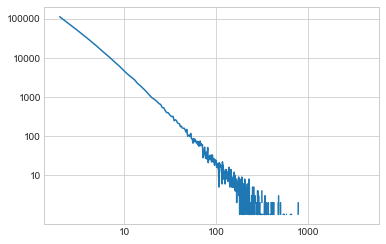

In [7]:
counts = np.array(counts)
totals = np.array(totals)
plt.plot(np.log10(totals),np.log10(counts))
xlab = np.array([1,2,3])
plt.xticks(
    xlab,
    np.power(10, xlab)
)
ylab = np.array([1,2,3,4,5])
plt.yticks(
    ylab,
    np.power(10, ylab)
)

save_figure("log-log citation degree distribution")

In [24]:
print( 
    "(%s)"%
    ") (".join( [
        " ".join(x) 
        for x in sorted(cysum.keys(), key=lambda x:-cysum[x]['total'])[:250] 
    ] ) )

(united states) (previous research) (less likely) (men women) (mental health) (labor force) (labor market) (social class) (socioeconomic status) (social networks) (previous studies) (social support) (educational attainment) (higher levels) (one another) (high school) (may also) (marriage family) (social movements) (social control) (recent years) (family members) (life course) (family life) (social structure) (life satisfaction) (quality life) (social problems) (high levels) (attitudes toward) (per cent) (social capital) (social science) (social economic) (women men) (human capital) (world war) (social life) (several studies) (health care) (african americans) (new york) (social relations) (recent studies) (social change) (social scientists) (even though) (journal marriage) (lower levels) (social sciences) (collective action) (division labor) (higher education) (journal sociology) (ethnic groups) (social movement) (working class) (sociological review) (middle class) (th century) (america

In [8]:
import statsmodels.api as sm

In [9]:
lt,lc = [x for i,x in enumerate(totals) if (totals[i]>0 and counts[i]>0)], [x for i,x in enumerate(counts) if (totals[i]>0 and counts[i]>0)]
lt,lc = np.log(lt),np.log(lc)

X = sm.add_constant(lt)
y = lc

mod = sm.OLS(y,X)

In [10]:
res = mod.fit()

In [11]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     3843.
Date:                Wed, 06 May 2020   Prob (F-statistic):          3.65e-213
Time:                        21:59:27   Log-Likelihood:                -451.71
No. Observations:                 421   AIC:                             907.4
Df Residuals:                     419   BIC:                             915.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1668      0.170     71.679      0.000      11.833      12.500
x1            -1.9831      0.032    -61.992      0.000      -2.046      -1.920
==============================================================================
Omnibus:                       61.739   Durbin-Watson:                   0.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.661
Skew:                           0.654   Prob(JB):                     5.37e-43
Kurtosis:                       6.064   Cond. No.                         26.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""